In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import h5py
import numpy as np
import pandas as pd  
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import matplotlib
from datetime import time, timedelta, datetime
from dateutil.relativedelta import relativedelta
from scipy.stats import chi2
# from whakaari import datetimeify
# from tsfresh.transformers import FeatureSelector
from textwrap import wrap
from matplotlib.animation import FuncAnimation,PillowWriter
import os
import re
import h5py
import obspy

In [2]:
def plot_mechanical(df_mechanical,df_catalog, injection_start, ith,xlim,legend_loc,fig_title):

    time_MEQ = df_catalog['Time']
    time_MEQ = [obspy.UTCDateTime(i) for i in time_MEQ]
    inj_start = obspy.UTCDateTime(injection_start)
    time_MEQ_ref = [t - inj_start for t in time_MEQ]
    mag = df_catalog['MwA']


    topflow =df_mechanical['topflow']*60
    toppressure = df_mechanical['toppressure']/10**6
    bottompressure = df_mechanical['bottompressure']
    time = df_mechanical['time']
    injectivity = topflow/toppressure
    fig = plt.figure(figsize=(9,6))
    gs = fig.add_gridspec(2,hspace=0)
    axs = gs.subplots(sharex=True)
    tkw =dict(size=8,width=1.5)
    fz=14
    p0,= axs[0].plot(time,toppressure,'k-',label='Pressure')
    axs_t1=axs[0].twinx()
    p1,=axs_t1.plot(time,topflow,'b-',label=r'Injection rate')
    axs[0].yaxis.label.set_color(p0.get_color())
    axs_t1.yaxis.label.set_color(p1.get_color())
    axs[0].tick_params(axis='y', colors=p0.get_color(), labelsize=fz,**tkw)
    axs_t1.tick_params(axis='y', colors=p1.get_color(),labelsize=fz, **tkw)
    axs_t1.spines['right'].set_color(p1.get_color())
    axs[0].set_ylabel(r'Pressure [MPa]',fontsize=fz)
    axs_t1.set_ylabel(r'Injection rate [$m^3$/min] ',fontsize=fz)#[$m^3$/min]
    axs_t1.ticklabel_format(axis='y',style='scientific',scilimits=(0,0))
    axs[0].plot([],[],'b-',label=r'Injection rate')
    axs[0].tick_params(axis='x',labelsize=fz, **tkw)
    axs[0].legend(loc=legend_loc,fontsize=fz)
    axs[0].text(0.05, 0.90, 'b1',fontsize=fz, horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)


    p20,=axs[1].plot(time,injectivity,'k-',label=r'Injectivity')##raw INjectivity##$\mathit{I}$
    axs_t2=axs[1].twinx()
    axs_t2.scatter(time_MEQ_ref,mag,s=20,marker = 'o',facecolors='none', edgecolors='r',label='Magnitude')
    axs[1].scatter([],[],s=20,marker = 'o',facecolors='none', edgecolors='r',label='Magnitude')

    axs_t2.yaxis.label.set_color('r')
    axs_t2.tick_params(axis='y', colors='r',labelsize=fz, **tkw)
    axs_t2.spines['right'].set_color('r')
    axs_t2.set_ylabel(r'Magnitude',fontsize=fz)

    axs[1].set_ylabel(r'Injectivity [$m^3$/min/MPa]',fontsize=fz)##$\mathit{I}$ [$m^3$/min/MPa]
    axs[1].tick_params(axis='x',labelsize=fz, **tkw)
    axs[1].tick_params(axis='y',labelsize=fz, **tkw)
#     axs[1].annotate('1e3', xy=(0.05, 0.98), xycoords='axes fraction',
#                 textcoords='offset points', ha='right', va='top')
    axs[1].ticklabel_format(axis='y',style='scientific',scilimits=(0,0))
    # axs[1].yaxis.get_offset_text().set_position((-0.05,0.8))
#     offset_text = axs[1].yaxis.get_offset_text()
#     offset_text.set_position((0, 0.5))  # You need to experiment with these values
#     offset_text.set_transform(axs[1].transAxes) 
    # axs[1].yaxis.get_offset_text().set_verticalalignment('bottom')
    # axs[1].yaxis.get_offset_text().set_pad(20)  # Adjust the padding as needed
    axs[1].legend(loc=legend_loc,fontsize=fz)
    axs[1].text(0.95, 0.9, 'b2',fontsize=fz, horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes)
    axs[1].set_xlabel('Time [s]',fontsize=fz)
    axs[1].set_xlim(xlim[0],xlim[1])
    fig.suptitle(fig_title, fontsize=fz+2)
    fig.text(0.1, 0.95, 'B', ha='center', va='center', fontsize=16)
    plt.tight_layout()
    plt.show()
    return

In [3]:
# Function to extract the number from the filename
def extract_number(filename):
    match = re.search(r'Int(\d+)_Ph1_filtered.h5', filename)
    if match:
        return int(match.group(1))
    return float('inf')  # Return a default large number if no match

In [4]:
mecha_path=r'/Bedretto/HydroData/Phase1'
catalog_path=r'/Bedretto/BULGGHighQualitySeismicCatalogs/Phase1'
# List all files in the directory
files = os.listdir(mecha_path)
# Filter to get only the 'filtered' files
filtered_files = [file for file in files if 'filtered' in file]

In [5]:
# Sort the files based on the extracted number
filtered_files_sorted = sorted(filtered_files, key=extract_number,reverse=False)

df_list=[]
for filename in filtered_files_sorted:
    # Construct the full file path
    file_path = os.path.join(mecha_path, filename)

    # Open the HDF5 file
    with h5py.File(file_path, 'r') as file:
        # Access the 'df' group
        if 'df' in file:
            df_group = file['df']
            print(f"Contents of 'df' group in {filename}: {list(df_group.keys())}")
            
            # Iterate over items in the 'df' group and print datasets
            # for name in df_group.keys():
            #     dataset = df_group[name]
                # print(f"Data in dataset '{name}':", dataset[:])  # Access data of each dataset
                # if dataset.dtype.char == 'S':  # Check if data type is a string (byte string)
                #     data = [x.decode('utf-8') for x in dataset[:]]  # Decode each byte string to a regular string
                # else:
                #     data = dataset[:]
                # print(f"Data in dataset '{name}':", data)
            # Extract and decode column names from byte strings
            column_names = [name.decode('utf-8') for name in df_group['block0_items'][:]]
            # Extract the values
            values = df_group['block0_values'][:]
            # Create a DataFrame using the decoded column names and the values
            df = pd.DataFrame(data=values, columns=column_names)
            df_list.append(df)

                
        else:
            print(f"'df' group not found in {filename}")

Contents of 'df' group in HydroData_Int7_Ph1_filtered.h5: ['axis0', 'axis1', 'block0_items', 'block0_values']
Contents of 'df' group in HydroData_Int8_Ph1_filtered.h5: ['axis0', 'axis1', 'block0_items', 'block0_values']
Contents of 'df' group in HydroData_Int9_Ph1_filtered.h5: ['axis0', 'axis1', 'block0_items', 'block0_values']
Contents of 'df' group in HydroData_Int10_Ph1_filtered.h5: ['axis0', 'axis1', 'block0_items', 'block0_values']
Contents of 'df' group in HydroData_Int11_Ph1_filtered.h5: ['axis0', 'axis1', 'block0_items', 'block0_values']
Contents of 'df' group in HydroData_Int12_Ph1_filtered.h5: ['axis0', 'axis1', 'block0_items', 'block0_values']
Contents of 'df' group in HydroData_Int13_Ph1_filtered.h5: ['axis0', 'axis1', 'block0_items', 'block0_values']
Contents of 'df' group in HydroData_Int14_Ph1_filtered.h5: ['axis0', 'axis1', 'block0_items', 'block0_values']


In [6]:
# get the required catalog
catalog_files = os.listdir(catalog_path)
# Filter to get only the 'filtered' files
catalog_filtered_files = [file for file in catalog_files if 'HypoDDLoc' in file]

# Function to extract the number from the filename
def extract_number_catalog(filename):
    match = re.search(r'Int(\d+)_Ph1_HypoDDLoc', filename)
    if match:
        return int(match.group(1))
    return float('inf')  # Return a default large number if no match
  

# Sort the files based on the extracted number
catalog_filtered_files_sorted = sorted(catalog_filtered_files, key=extract_number_catalog,reverse=False)

df_catalog_list=[]
for filename in catalog_filtered_files_sorted:
    # Construct the full file path
    file_path = os.path.join(catalog_path, filename)

    df_catalog = pd.read_csv(file_path,header=0)

    df_catalog_list.append(df_catalog)

In [7]:
injection_start_list = [datetime(2021, 11, 17, 10,10,0),datetime(2022, 2, 9, 13,40,0),datetime(2022, 2, 16, 9,10,0),datetime(2022, 3, 2, 10,0,0),
                        datetime(2022, 3, 9, 8,50,0),datetime(2022, 3, 16, 9,0,0),datetime(2022, 3, 23, 10,40,0),datetime(2022, 3, 30, 7,50,0)]


In [8]:
## xlabel list
fig_title_list=['Phase 1--interval {}'.format(i) for i in range(7,15)]
xlim_list=[(0,33800),(0,17250),(0,30000),(0,22600),(0,33800),(0,22100),(0,28200),(0,20000)]
legend_loc_list=[(0.3,0.7),(0.3,0.7),(0.3,0.7),(0.4,0.7),(0.45,0.7),(0.3,0.7),(0.3,0.7),(0.4,0.7)]

<IPython.core.display.Javascript object>


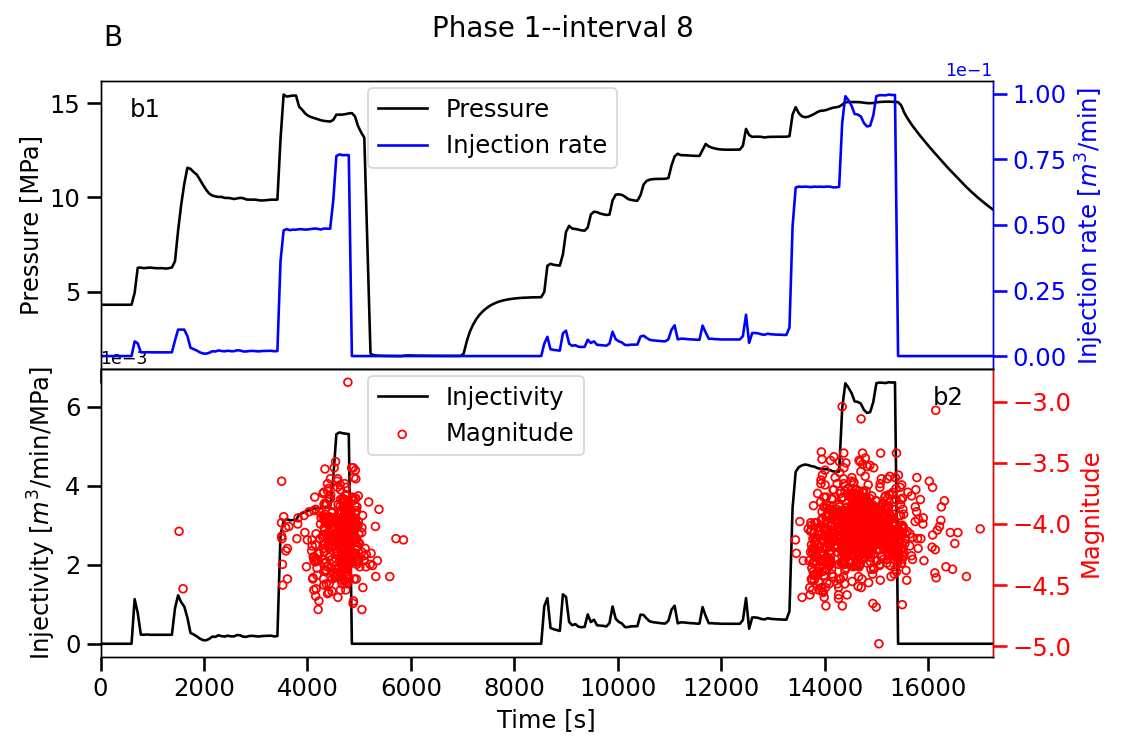

In [9]:
i=1

df_mechanical = df_list[i]
df_catalog = df_catalog_list[i]
injection_start = injection_start_list[i]
ith = i+7
xlim=xlim_list[i]
legend_loc=legend_loc_list[i]
fig_title =  fig_title_list[i]

plot_mechanical(df_mechanical, df_catalog, injection_start,ith,xlim,legend_loc,fig_title)

In [10]:
stimulation_point_list=[(-141.66384420093007,-91.98597068835039,1312.256652739279),(-125.99908557835657,-77.47903633957081,1337.156190936656),
                        (-114.85512307821624,-67.02635722496237,1354.614310538186),(-105.52950633658389,-58.24588619292117,1368.9172360132895),
                        (-96.60571311635368,-49.756271505278235,1382.4515964256707),(-89.57376738113274,-43.0380614181888,1392.9351518489511),
                        (-81.82198790861928,-35.584568497591725,1404.373714803893),(-63.02653625360609,-18.192356228185112,1431.0786731527205),
                        (-110.2006655121233,-62.64973470975164,1361.7795774400345)]

cycle1_lim=(0,6500)
cycle2_lim=(6500,17160)

In [12]:
time_MEQ = df_catalog['Time']
time_MEQ = [obspy.UTCDateTime(i) for i in time_MEQ]
inj_start = obspy.UTCDateTime(injection_start)
time_MEQ_ref = [t - inj_start for t in time_MEQ]
mag = df_catalog['MwA']


topflow =df_mechanical['topflow']*60
toppressure = df_mechanical['toppressure']/10**6
bottompressure = df_mechanical['bottompressure']
time = df_mechanical['time']
injectivity = topflow/toppressure
time_range_inj= [14360,14938]
injectivity_update = injectivity.copy()
time_range_big = [14325,14938]

In [13]:
def inj_update(time, time_range_inj, injectivity_update, time_range_big):
    ind_range = np.where((time>=time_range_inj[0]) & (time<=time_range_inj[1]))[0]
    inj_localmin = np.min(injectivity_update[ind_range])
    min_value_index = np.where(injectivity_update == inj_localmin)[0][0]
    ind_range_big = np.where((time>=time_range_big[0]) & (time<=time_range_big[1]))[0]
    for ind in ind_range_big:
        if (ind <=min_value_index) and (injectivity_update[ind]>=inj_localmin):
            injectivity_update[ind] = inj_localmin
    return injectivity_update

In [14]:
injectivity_update = inj_update(time, time_range_inj, injectivity_update, time_range_big)

In [15]:
time_range_inj1= [13619,14286]
time_range_big1 = [13413,14286]
injectivity_update = inj_update(time, time_range_inj1, injectivity_update, time_range_big1)

In [16]:
time_range_inj2= [15002,15356]
time_range_big2 = [14995,15356]
injectivity_update = inj_update(time, time_range_inj2, injectivity_update, time_range_big2)

In [17]:
def MEQ_radius(df_mechanical,df_catalog, injection_start,stimulation_point, time_lim, DD, injectivity_update,topflow):
    time_MEQ = df_catalog['Time']
    time_MEQ = [obspy.UTCDateTime(i) for i in time_MEQ]
    inj_start = obspy.UTCDateTime(injection_start)
    time_MEQ_ref = np.array([t - inj_start for t in time_MEQ])
    mag = df_catalog['MwA']
    
    eastern = df_catalog['Eastern Bedretto']
    northern = df_catalog['Northern Bedretto']
    depth = df_catalog['Depth']
    sti_eastern =stimulation_point[0]
    sti_northern =stimulation_point[1]
    sti_depth =stimulation_point[2]
    time = df_mechanical['time']
    
    radius = np.sqrt((eastern-sti_eastern)**2 + (northern-sti_northern)**2 + (depth - sti_depth)**2)
    ind = np.where((time_MEQ_ref>=time_lim[0])&(time_MEQ_ref<=time_lim[1]))[0]
    radius_sim = radius[ind]
    time_MEQ_ref_sim = time_MEQ_ref[ind]
    ## covnert time series into time points with hour unit, starting the first point of the event:
    tt1 = np.array([(i-time_MEQ_ref_sim[0])/3600 for i in time_MEQ_ref_sim])
    R_flow=(tt1*3600*4*np.pi*DD)**0.5
    mag_sim = mag[ind]
    M0 = 1.5*mag_sim+27/2 ## seismic moment magnitude
    
    indd= np.where((time>=time_lim[0])&(time<=time_lim[1]))[0]
    topflow_sim = np.array(topflow[indd])
    
    time_sim = np.array(time[indd])
    ind_sim = np.where((time_sim-time_MEQ_ref_sim[0]>0))[0]
#     print(len(time_sim))
    topflow_sim_sh=topflow_sim[ind_sim]
    time_sim_sh= time_sim[ind_sim]
#     print(len(time_sim))
    tt1_inj_sim = np.array([(i-time_MEQ_ref_sim[0])/3600 for i in time_sim_sh])
    R_flow_interp =np.interp(tt1_inj_sim, tt1,R_flow )
    print(len(R_flow_interp))
    injectivity_update_sim = np.array(injectivity_update[indd])
    injectivity_update_sim1 = injectivity_update_sim [ind_sim]
    print(len(injectivity_update_sim1))
    mu= 1*10**-3 ##pa*s at 20 degC
    rw = 8.5*2.54*1e-2 ## 8 ½ inch
    interval_length = 30.1 ## meter
    kk = mu * (injectivity_update_sim1/60/1e6) / 2/np.pi/interval_length*np.log(R_flow_interp/rw)
    kini = np.ones(len(injectivity_update_sim)-len(injectivity_update_sim1))*kk[0]
    kk_full = np.concatenate((kini,kk))
    print(len(kk_full))
    ## extract MEQs features of cumulative MEQ and seismicity rate
    lambda_list=[]## 2min delay
    cum_mag_list =[]
    for i  in range(len(time_sim_sh)):
        t = time_sim_sh[i]
        t2min = t+2*60
        ind = np.where((time_MEQ_ref_sim>=t)&(time_MEQ_ref_sim<t2min))[0]
        rate = len(ind)/2 ## number/min
        lambda_list.append(rate)
        
        event_index = np.where(time_MEQ_ref_sim< t2min)[0]
        cum_mag = np.sum(np.array(M0)[event_index])
        cum_mag_list.append(cum_mag)
    
    return R_flow, time_MEQ_ref_sim, mag_sim, radius_sim, R_flow_interp, time_sim,time_sim_sh, kk,kk_full, lambda_list,cum_mag_list,topflow_sim_sh

In [18]:
stimulation_point = stimulation_point_list[1]
time_lim=[12640,33800]
R_flow, time_MEQ_ref_sim, mag_sim, radius_sim,R_flow_interp, time_sim,time_sim_sh,kk,kk_full,lambda_list,cum_mag_list,topflow_sim_sh = MEQ_radius(df_mechanical, df_catalog, injection_start,stimulation_point, time_lim, 0.05,injectivity_update,topflow)

R_flow1, time_MEQ_ref_sim, mag_sim, radius_sim ,R_flow_interp1, time_sim,time_sim_sh,kk1, kk_full1, lambda_list,cum_mag_list,topflow_sim_sh= MEQ_radius(df_mechanical, df_catalog, injection_start,stimulation_point, time_lim, 0.1,injectivity_update,topflow)
R_flow2, time_MEQ_ref_sim, mag_sim, radius_sim,R_flow_interp2, time_sim,time_sim_sh,kk2,kk_full2,lambda_list,cum_mag_list,topflow_sim_sh = MEQ_radius(df_mechanical, df_catalog, injection_start,stimulation_point, time_lim, 0.07,injectivity_update,topflow)


336
336
349
336
336
349
336
336
349


In [19]:
KK_change= np.log10(kk)-np.log10(kk[0])

/tmp/ipykernel_1372080/1219019501.py:1: RuntimeWarning: divide by zero encountered in log10
  KK_change= np.log10(kk)-np.log10(kk[0])


<IPython.core.display.Javascript object>


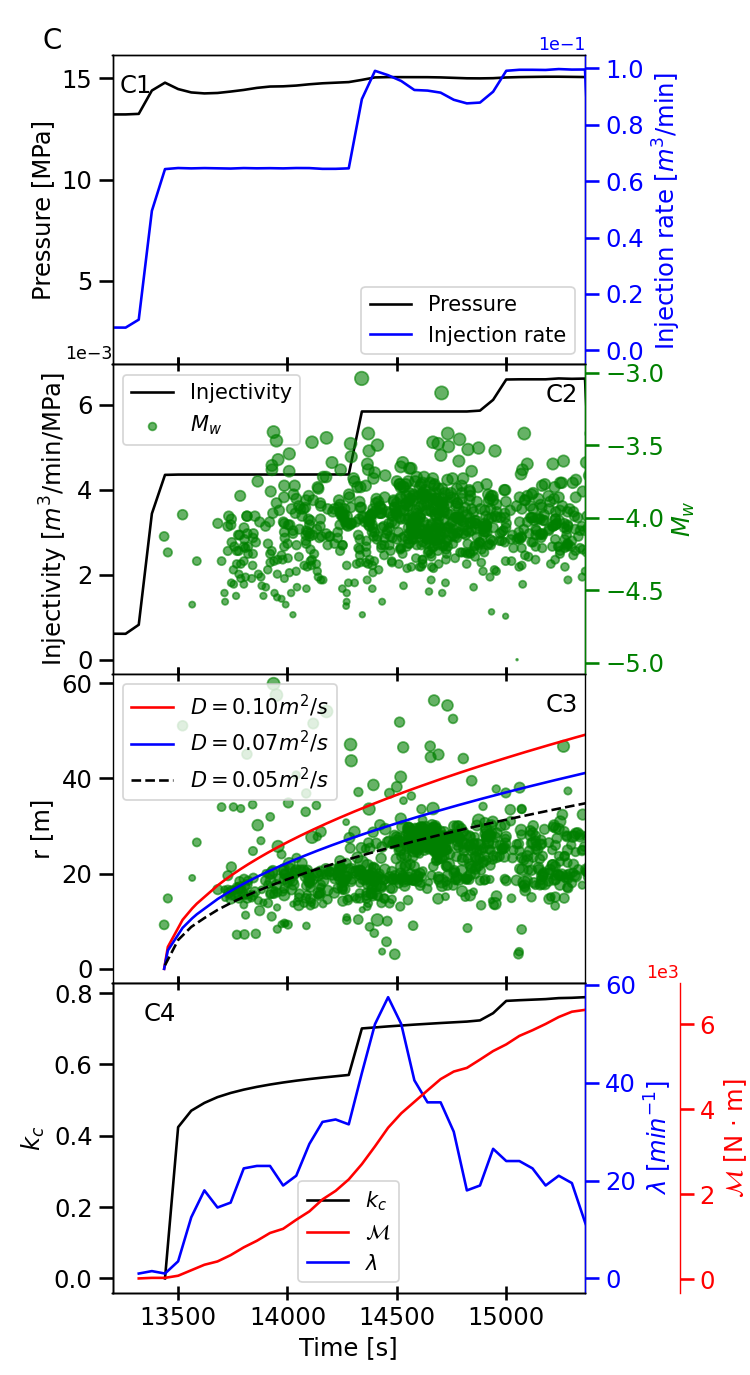

In [21]:
time_MEQ = df_catalog['Time']
time_MEQ = [obspy.UTCDateTime(i) for i in time_MEQ]
inj_start = obspy.UTCDateTime(injection_start)
time_MEQ_ref = [t - inj_start for t in time_MEQ]
mag = df_catalog['MwA']


topflow =df_mechanical['topflow']*60
toppressure = df_mechanical['toppressure']/10**6
bottompressure = df_mechanical['bottompressure']
time = df_mechanical['time']
injectivity = topflow/toppressure


fig = plt.figure(figsize=(6,11))
gs = fig.add_gridspec(4,hspace=0,left=0.15,right=0.78,top=0.96,bottom=0.06)
axs = gs.subplots(sharex=True)
tkw =dict(size=8,width=1.5)
fz=14
p0,= axs[0].plot(time,toppressure,'k-',label='Pressure')
axs_t1=axs[0].twinx()
p1,=axs_t1.plot(time,topflow,'b-',label=r'Injection rate')
axs[0].yaxis.label.set_color(p0.get_color())
axs_t1.yaxis.label.set_color(p1.get_color())
axs[0].tick_params(axis='y', colors=p0.get_color(), labelsize=fz,**tkw)
axs_t1.tick_params(axis='y', colors=p1.get_color(),labelsize=fz, **tkw)
axs_t1.spines['right'].set_color(p1.get_color())
axs[0].set_ylabel(r'Pressure [MPa]',fontsize=fz)
axs_t1.set_ylabel(r'Injection rate [$m^3$/min] ',fontsize=fz)#[$m^3$/min]
axs_t1.ticklabel_format(axis='y',style='scientific',scilimits=(0,0))
axs[0].plot([],[],'b-',label=r'Injection rate')
axs[0].tick_params(axis='x',labelsize=fz, **tkw)
axs[0].legend(loc='lower right',fontsize=fz-2)
axs[0].text(0.05, 0.90, 'C1',fontsize=fz, horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)


p20,=axs[1].plot(time,injectivity_update,'k-',label=r'Injectivity')##raw INjectivity##$\mathit{I}$
axs_t2=axs[1].twinx()
s=(mag-np.min(mag))/(np.max(mag)-np.min(mag))
s=s*60+1

# axs_t2.scatter(time_MEQ_ref,mag,s=s,marker = 'o',color='g',alpha=0.6,label='$M_w$')##facecolors='none', edgecolors='g',

axs[1].scatter([],[],s=20,marker = 'o',color='g',alpha=0.6,label='$M_w$')#facecolors='none', edgecolors='g'

axs_t2.yaxis.label.set_color('g')
axs_t2.tick_params(axis='y', colors='g',labelsize=fz, **tkw)
axs_t2.spines['right'].set_color('g')
axs_t2.set_ylabel(r'$M_w$',fontsize=fz)

axs[1].set_ylabel(r'Injectivity [$m^3$/min/MPa]',fontsize=fz)##$\mathit{I}$ [$m^3$/min/MPa]
axs[1].tick_params(axis='x',labelsize=fz, **tkw)
axs[1].tick_params(axis='y',labelsize=fz, **tkw)
# axs[1].annotate('1e3', xy=(0.05, 0.98), xycoords='axes fraction',
#             textcoords='offset points', ha='right', va='top')
axs[1].ticklabel_format(axis='y',style='scientific',scilimits=(0,0))
axs[1].yaxis.get_offset_text().set_position((-0.1,0.8))
# offset_text = axs[1].yaxis.get_offset_text()
# offset_text.set_position((0, 0.5))  # You need to experiment with these values
# offset_text.set_transform(axs[1].transAxes) 
# axs[1].yaxis.get_offset_text().set_verticalalignment('bottom')
# axs[1].yaxis.get_offset_text().set_pad(20)  # Adjust the padding as needed
axs[1].legend(loc='best',fontsize=fz-2)
axs[1].text(0.95, 0.9, 'C2',fontsize=fz, horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes)
axs[1].set_xlabel('Time [s]',fontsize=fz)
axs[1].set_xlim(13200,15360)

mag_sim=[]
for i in range(len(time_MEQ_ref_sim)):
    tt = time_MEQ_ref_sim[i]
    ind = np.where(time_MEQ_ref==tt)[0][0]
    mag_sim.append(mag[ind])
    
s_sim=(mag_sim-np.min(mag_sim))/(np.max(mag_sim)-np.min(mag_sim))
s_sim=s_sim*60+1
axs_t2.scatter(time_MEQ_ref_sim,mag_sim,s=s_sim,marker = 'o',color='g',alpha=0.6,label='$M_w$')##facecolors='none', edgecolors='g',

## axs[3]:
axs[2].scatter(time_MEQ_ref_sim , radius_sim, color='g', s=s_sim, alpha = 0.6)##6 min delay
# axs[2].plot(time_MEQ_ref_sim, R_flow, 'k',label='$D=0.05 m^2/s$')
axs[2].plot(time_MEQ_ref_sim, R_flow1,'r',label='$D=0.10 m^2/s$')
axs[2].plot(time_MEQ_ref_sim, R_flow2,'b',label='$D=0.07 m^2/s$')

axs[2].plot(time_sim_sh,R_flow_interp, 'k--',label='$D=0.05 m^2/s$')

axs[2].set_xlabel('Time [s]',fontsize=fz)
axs[2].set_ylabel(r'r [m]',fontsize=fz)##$\mathit{I}$ [$m^3$/min/MPa]
axs[2].tick_params(axis='x',labelsize=fz, **tkw)
axs[2].tick_params(axis='y',labelsize=fz, **tkw)


axs[2].legend(loc='best',fontsize=fz-2)
axs[2].set_ylim(-3,62)
axs[2].text(0.95, 0.9, 'C3',fontsize=fz, horizontalalignment='center', verticalalignment='center', transform=axs[2].transAxes)


# axs[3].plot(time_sim_sh, kk, 'k', label='permeability')
axs[3].plot(time_sim_sh, KK_change, 'k', label=r'$k_c$')
axs[3].set_xlabel('Time [s]',fontsize=fz)
# axs[3].set_ylabel(r'Permeability [$m^2$]',fontsize=fz)##$\mathit{I}$ [$m^3$/min/MPa]
axs[3].set_ylabel(r'$k_c$ ',fontsize=fz)##$\mathit{I}$ [$m^3$/min/MPa]$[$log(m^2)$]
axs[3].tick_params(axis='x',labelsize=fz, **tkw)
axs[3].tick_params(axis='y',labelsize=fz, **tkw)
# axs[3].set_yscale('log')

axs3_t  = axs[3].twinx()
ps3t,= axs3_t.plot(time_sim_sh-120, lambda_list, 'b-',label=r'$\lambda$') ##2 mins delay
axs3_t.yaxis.label.set_color(ps3t.get_color())

axs3_t.tick_params(axis='y', colors=ps3t.get_color(),labelsize=fz, **tkw)
axs3_t.spines['right'].set_color(ps3t.get_color())

axs3_t.set_ylabel(r'$\lambda$ [$min^{-1}$]',fontsize=fz)##$\mathit{I}$ [$m^3$/min/MPa]
axs3_t.tick_params(axis='y',labelsize=fz, **tkw)


axs4_t = axs[3].twinx()
ps4t,= axs4_t.plot(time_sim_sh-120, np.array(cum_mag_list),'r-',label=r'$\mathcal{M}$')#2 mins delay
axs4_t.yaxis.label.set_color(ps4t.get_color())
axs4_t.tick_params(axis='y', colors=ps4t.get_color(),labelsize=fz, **tkw)
axs4_t.spines['right'].set_position(('axes',1.2))
axs4_t.spines['right'].set_color(ps4t.get_color())
axs4_t.set_ylabel(r'$\mathcal{M}$ [N $\cdot$ m]',fontsize=fz)
axs4_t.ticklabel_format(axis='y',style='scientific',scilimits=(0,0))
axs4_t.yaxis.get_offset_text().set_position((1.2,1.05))

axs[3].plot([],[],'r-',label=r'$\mathcal{M}$')
axs[3].plot([],[],'b-',label=r'$\lambda$')
axs[3].legend(loc='lower center',fontsize=fz-2)
axs[3].text(0.1, 0.9, 'C4',fontsize=fz, horizontalalignment='center', verticalalignment='center', transform=axs[3].transAxes)

for ax in axs:
    ax.tick_params(axis='x', which='both', bottom=True, top=True,direction='inout')
axs[0].tick_params(axis='x', which='both', top=False)
fig.text(0.07, 0.97, 'C', ha='center', va='center', fontsize=16)
# fig.suptitle(fig_title, fontsize=fz+2)
# plt.tight_layout()
plt.show()